In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.utils import shuffle
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import KFold

from treend import *
from reg_tree import *

from os import listdir
from os.path import isfile, join

# online source :https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data

data_path = "../../../../machine learning/checkdatasets/PRSA_Data_20130301-20170228/"


files = [f for f in listdir(data_path)]

frames= []
for file in files:
    if file[-4:] == ".csv" :
        d = pd.read_csv(data_path+file)
        frames.append(d)

df = pd.concat(frames)

# for coding purpose, use a smaller dataset
df=df.sample(frac=.02)

# only predict O3
df=df.drop(columns=['No','PM2.5', 'PM10', 'SO2', 'NO2', 'CO'])

# get attributes columns 
attributes = list(df.columns).copy()
attributes.remove('O3')

# drop every row having a missing value in O3, our target, or in station (we do not know from where the data comes from)
df.dropna(subset=["O3","station"], inplace=True)

df_origin = df.copy()

df.head()

,year,month,day,hour,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
4843,2013,9,18,19,75.0,21.9,1010.5,20.0,0.0,E,0.9,Wanshouxigong
7294,2013,12,29,22,3.0,-4.6,1013.7,-12.7,0.0,N,0.1,Shunyi
18459,2015,4,9,3,2.0,5.0,1018.0,0.6,0.0,NE,0.1,Shunyi
8397,2014,2,13,21,7.0,-2.7,1023.4,-6.5,0.0,ESE,1.2,Gucheng
4060,2013,8,17,4,36.0,28.0,991.0,16.9,0.0,NNW,1.4,Changping


In [59]:
# returns a table with the percentage of missing values in the first column and the number of samples concerned in the second   

def number_of_samples_per_number_of_missing_values(data) :
    # count how many rows have 'x' missing values
    m = data.copy()
    n = m.isna().sum(axis=1)
    n.name = "missing values in row"
    d = n.value_counts(sort=False)
    return d
number_of_samples_per_number_of_missing_values(df).map(lambda x: x/len(df))

0    0.995827
4    0.000123
1    0.003559
6    0.000491
Name: missing values in row, dtype: float64

In [60]:
# returns a table with the percentage of missing values per attribute

df.isna().sum().map(lambda x: x/len(df))

year       0.000000
month      0.000000
day        0.000000
hour       0.000000
O3         0.000000
TEMP       0.000614
PRES       0.000614
DEWP       0.000614
RAIN       0.000614
wd         0.004050
WSPM       0.000491
station    0.000000
dtype: float64

In [61]:
df.describe()

,year,month,day,hour,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,8148.000000,8148.000000,8148.000000,8148.000000,8148.000000,8143.000000,8143.000000,8143.000000,8143.000000,8144.000000
mean,2014.662494,6.486991,15.626043,11.489200,56.991493,13.466426,1010.814878,2.452290,0.063134,1.730071
std,1.174368,3.449786,8.859136,6.943388,56.084888,11.486364,10.548557,13.873678,0.748035,1.245718
min,2013.000000,1.000000,1.000000,0.000000,0.214200,-18.900000,984.300000,-33.800000,0.000000,0.000000
25%,2014.000000,4.000000,8.000000,5.000000,11.000000,3.100000,1002.200000,-9.000000,0.000000,0.900000
50%,2015.000000,6.000000,15.000000,11.000000,45.000000,14.300000,1010.300000,3.000000,0.000000,1.400000
75%,2016.000000,9.000000,23.000000,18.000000,81.000000,23.200000,1019.100000,15.100000,0.000000,2.200000
max,2017.000000,12.000000,31.000000,23.000000,385.000000,39.300000,1040.800000,28.600000,36.900000,9.600000


We can see that our dataset has relatively a small amount of missing values, so we will delete the missing values (we can assume that these values are Missing Completely at Random, ie the fact that the value is missing has nothing to do with its hypothetical value and with the values of other variables, because here we it is just a lack of data due to weather station and we can suppose that no bias is introduced if we drop rows with missing values.
To be sure of this assumption, we will try with the total deletion of the rows with missing values (here printed for the preprocessing), and then with a threshold of 3 missing values at most for a row, and finally with an imputation for everything.
We will use two kind of preprocessing: mean value (and most common value for non numeral values) and 5NN.

# Preprocessing

In [62]:
from sklearn.impute import KNNImputer

# drop rows with missing values

def dropRows(df, wds=[], thres=0, imputation=None) :
    
    if imputation == "mean" :
        # wind direction is nominal so we have to check for every created column (wds)
        for wd in wds :
            df[wd] = df[wd].fillna(df[wd].mode()[0])
        # for numeral values
        missing_list = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
        for name in missing_list:
            df[name] = df[name].fillna(df[name].mean())
        return df
    elif imputation == "5NN" :
        imp = KNNImputer(n_neighbors=5)
        # we fit the multivariate feature imputation
        imp.fit(df)
        # we use it on training dataset
        array = imp.transform(df)
        return pd.DataFrame(array, columns = df.columns)
    else :
        return df.dropna(thresh=len(df.columns)-thres)
    
df = dropRows(df)

<Figure size 432x288 with 0 Axes>

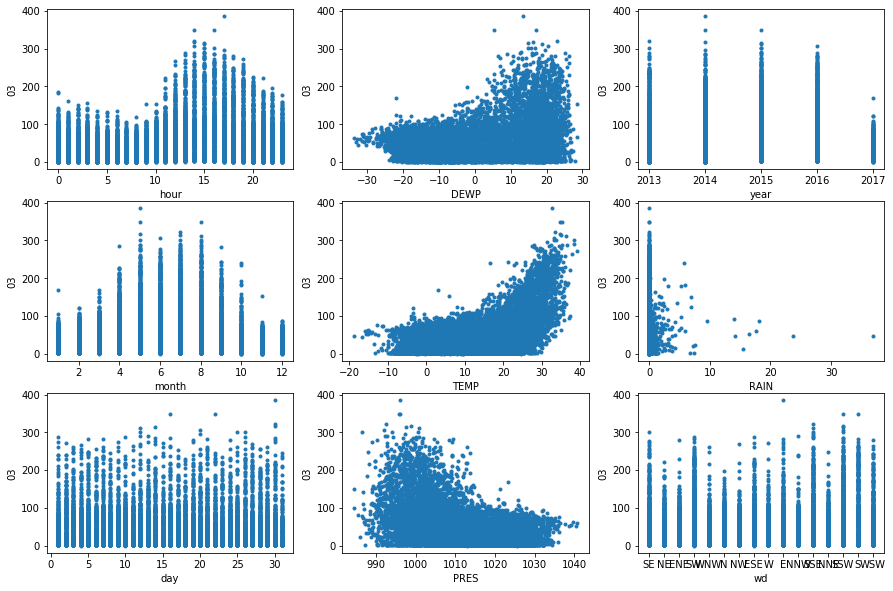

In [63]:
# plots scatter graph with the mean value of the target for each value of the attribute (string imput)
# log is true when we want to plot it with a logarithmic scale

def plotTargetPerAttribute(data, attribute, ax=plt, logx=False, logy=False) :
    if logx :
        ax.semilogx(data[attribute], data["O3"])
    elif logy :
        ax.semilogy(data[attribute], data["O3"])
    else :
        ax.plot(data[attribute], data["O3"], '.')
    ax.set(xlabel=attribute)
    ax.set(ylabel="03")
    #ax.savefig("./max_iter_ppn.pdf")

def plotAllAttributes(data) :
    plt.clf()
    fig, axs = plt.subplots(3,3, figsize = (15,10))
    j = -1
    for i in range(9) :
        attribute = attributes[i]
        plotTargetPerAttribute(data, attribute, axs[i%3][j])
        if i%3 == 0:
            j += 1
    plt.savefig("./plotAllAttributes.pdf")

plotAllAttributes(df)

In [68]:
def removeOutliers(df) :
    if 'O3' in df.columns :
        df = df[df['O3'] < 1000]
    return df
    
# get the O3 index
indO3 = None

# returns the 5 datasets with the 5 methods of preprocessing

def preprocessing(df) :
    # encode columns by one hot
    df = pd.get_dummies(df, columns=["wd", "station"], prefix=["wd", "stat"])
    wds = [wdname for wdname in df.columns if wdname[:2] == "wd"]
    global indO3
    indO3 = list(df.columns).index('O3')

    df1 = dropRows(df, thres=0, imputation=None)
    df2 = dropRows(df, wds=wds, thres=4, imputation="mean")
    df3 = dropRows(df, wds=wds, thres=10, imputation="mean")
    df4 = dropRows(df, wds=wds, thres=4, imputation="5NN")
    df5 = dropRows(df, wds=wds, thres=10, imputation="5NN")
    DF = [df1,df2,df3,df4,df5]
    for i in range(len(DF)) :
        DF[i] = removeOutliers(DF[i])
        DF[i] = np.array(DF[i]).astype("float")
    return DF
 
def preprocessing_mean(df) :
    df = pd.get_dummies(df, columns=["wd", "station"], prefix=["wd", "stat"])
    wds = [wdname for wdname in df.columns if wdname[:2] == "wd"]
    df = dropRows(df, thres=0, imputation="mean")
    df = removeOutliers(df)
    return np.array(df).astype("float")

In [70]:
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=42)
split = kf.split(df_origin)
M5regressor_r2_model, const_regressor_r2 = [[] for i in range(5)], [[] for i in range(5)]
M5regressor_MAE_model, const_regressor_MAE = [[] for i in range(5)], [[] for i in range(5)]

# We split the data and apply the pre-processing

for train_index, test_index in split:
        array_train = df_origin.iloc[train_index]
        array_test = df_origin.iloc[test_index]
        
        trains = preprocessing(pd.DataFrame(data=array_train, columns=df_origin.columns))
        tests = preprocessing(pd.DataFrame(data=array_test, columns=df_origin.columns))

        for i in range(5) :
            y_train = trains[i][:,indO3]
            y_test = tests[i][:,indO3]
            X_train = np.delete(trains[i], indO3, axis=1)
            X_test = np.delete(tests[i], indO3, axis=1)
            
            #M5 regressor tree own
            reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=4,k=20.0,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
            M5regressor_r2_model[i].append(r2_score(y_test, reg.predict(X_test)))
            M5regressor_MAE_model[i].append(mean_absolute_error(y_test, reg.predict(X_test)))

            #Constant regressor tree own
            reg2 = Const_regressor(n_attr_leaf = 4, max_depth=8).fit(X_train, y_train[:,None])
            const_regressor_r2[i].append(r2_score(y_test, reg2.predict(X_test)))
            const_regressor_MAE[i].append(mean_absolute_error(y_test, reg2.predict(X_test)))
            
m5_r2, cons_r2 = [], []
for i in range(5):
    m5_r2.append(np.mean(M5regressor_r2_model[i]))
    cons_r2.append(np.mean(const_regressor_r2[i]))

print("m5_r2:", m5_r2)
print("cons_r2:", cons_r2)

(7330, 38)
(813, 38)
(7330,)
(813,)
(6520, 11)
(1630, 11)
calc split of 7330 points
dim, split 4 25.8
calc split of 6110 points
dim, split 4 17.1
calc split of 4129 points
dim, split 8 2.1
calc split of 2985 points
dim, split 1 9.0
calc split of 1574 points
dim, split 4 7.8
calc split of 1411 points
dim, split 4 10.0
calc split of 1144 points
dim, split 1 9.0
calc split of 758 points
dim, split 4 5.1
calc split of 386 points
dim, split 8 2.7
calc split of 1981 points
dim, split 3 12.0
calc split of 1075 points
dim, split 1 6.0
calc split of 254 points
dim, split 0 2015.0
calc split of 821 points
dim, split 8 1.3
calc split of 906 points
dim, split 1 6.0
calc split of 331 points
dim, split 4 22.7
calc split of 575 points
dim, split 4 21.0
calc split of 1220 points
dim, split 3 12.0
calc split of 369 points
dim, split 3 11.0
calc split of 282 points
dim, split 3 10.0
calc split of 222 points
dim, split 3 3.0
calc split of 60 points
dim, split 5 1001.5
calc split of 87 points
dim, split 2

calc split of 32 points
calc split of 7 points
calc split of 25 points
calc split of 9 points
calc split of 6 points
calc split of 4 points
calc split of 851 points
calc split of 460 points
calc split of 194 points
calc split of 34 points
calc split of 31 points
calc split of 28 points
calc split of 15 points
calc split of 13 points
calc split of 160 points
calc split of 70 points
calc split of 6 points
calc split of 64 points
calc split of 61 points
calc split of 90 points
calc split of 17 points
calc split of 14 points
calc split of 73 points
calc split of 47 points
calc split of 26 points
calc split of 266 points
calc split of 187 points
calc split of 161 points
calc split of 71 points
calc split of 14 points
calc split of 57 points
calc split of 90 points
calc split of 30 points
calc split of 60 points
calc split of 26 points
calc split of 25 points
calc split of 4 points
calc split of 21 points
calc split of 79 points
calc split of 22 points
calc split of 15 points
calc split of 1

calc split of 5 points
calc split of 9 points
calc split of 575 points
calc split of 212 points
calc split of 64 points
calc split of 26 points
calc split of 24 points
calc split of 38 points
calc split of 35 points
calc split of 148 points
calc split of 87 points
calc split of 60 points
calc split of 27 points
calc split of 61 points
calc split of 43 points
calc split of 18 points
calc split of 363 points
calc split of 218 points
calc split of 40 points
calc split of 30 points
calc split of 10 points
calc split of 178 points
calc split of 163 points
calc split of 15 points
calc split of 145 points
calc split of 62 points
calc split of 56 points
calc split of 6 points
calc split of 83 points
calc split of 34 points
calc split of 49 points
calc split of 1220 points
calc split of 369 points
calc split of 282 points
calc split of 222 points
calc split of 61 points
calc split of 15 points
calc split of 11 points
calc split of 7 points
calc split of 4 points
calc split of 4 points
calc spli

calc split of 142 points
calc split of 89 points
calc split of 79 points
calc split of 10 points
calc split of 53 points
calc split of 17 points
calc split of 36 points
calc split of 1981 points
calc split of 1075 points
calc split of 254 points
calc split of 125 points
calc split of 88 points
calc split of 60 points
calc split of 33 points
calc split of 27 points
calc split of 28 points
calc split of 4 points
calc split of 24 points
calc split of 37 points
calc split of 29 points
calc split of 7 points
calc split of 22 points
calc split of 8 points
calc split of 5 points
calc split of 129 points
calc split of 27 points
calc split of 15 points
calc split of 14 points
calc split of 12 points
calc split of 10 points
calc split of 102 points
calc split of 36 points
calc split of 19 points
calc split of 17 points
calc split of 66 points
calc split of 59 points
calc split of 7 points
calc split of 821 points
calc split of 507 points
calc split of 102 points
calc split of 95 points
calc spli

calc split of 341 points
calc split of 522 points
calc split of 315 points
calc split of 15 points
calc split of 9 points
calc split of 6 points
calc split of 300 points
calc split of 47 points
calc split of 253 points
calc split of 207 points
calc split of 180 points
calc split of 155 points
calc split of 25 points
calc split of 27 points
calc split of 13 points
calc split of 14 points
calc split of 1411 points
calc split of 964 points
calc split of 157 points
calc split of 138 points
calc split of 44 points
calc split of 94 points
calc split of 19 points
calc split of 13 points
calc split of 6 points
calc split of 807 points
calc split of 388 points
calc split of 284 points
calc split of 104 points
calc split of 419 points
calc split of 172 points
calc split of 247 points
calc split of 447 points
calc split of 80 points
calc split of 39 points
calc split of 36 points
calc split of 41 points
calc split of 32 points
calc split of 9 points
calc split of 367 points
calc split of 47 point

calc split of 10 points
calc split of 8 points
calc split of 6 points
calc split of 5 points
(7333, 38)
(815, 38)
(7333,)
(815,)
(6520, 11)
(1630, 11)
calc split of 7333 points
dim, split 4 25.8
calc split of 6113 points
dim, split 4 17.1
calc split of 4132 points
dim, split 8 2.1
calc split of 2988 points
dim, split 1 9.0
calc split of 1577 points
dim, split 4 7.8
calc split of 1411 points
dim, split 4 10.0
calc split of 1144 points
dim, split 1 9.0
calc split of 758 points
dim, split 4 5.1
calc split of 386 points
dim, split 8 2.7
calc split of 1981 points
dim, split 3 12.0
calc split of 1075 points
dim, split 1 6.0
calc split of 254 points
dim, split 0 2015.0
calc split of 821 points
dim, split 8 1.3
calc split of 906 points
dim, split 1 6.0
calc split of 331 points
dim, split 4 22.7
calc split of 575 points
dim, split 4 21.0
calc split of 1220 points
dim, split 3 12.0
calc split of 369 points
dim, split 3 11.0
calc split of 282 points
dim, split 3 10.0
calc split of 222 points
dim,

calc split of 5 points
calc split of 8 points
calc split of 6 points
calc split of 87 points
calc split of 83 points
calc split of 26 points
calc split of 4 points
calc split of 22 points
calc split of 20 points
calc split of 17 points
calc split of 57 points
calc split of 16 points
calc split of 15 points
calc split of 14 points
calc split of 41 points
calc split of 32 points
calc split of 7 points
calc split of 25 points
calc split of 9 points
calc split of 6 points
calc split of 4 points
calc split of 851 points
calc split of 460 points
calc split of 194 points
calc split of 34 points
calc split of 31 points
calc split of 28 points
calc split of 15 points
calc split of 13 points
calc split of 160 points
calc split of 70 points
calc split of 6 points
calc split of 64 points
calc split of 61 points
calc split of 90 points
calc split of 17 points
calc split of 14 points
calc split of 73 points
calc split of 47 points
calc split of 26 points
calc split of 266 points
calc split of 187 po

calc split of 62 points
calc split of 7 points
calc split of 479 points
calc split of 136 points
calc split of 16 points
calc split of 5 points
calc split of 4 points
calc split of 11 points
calc split of 5 points
calc split of 6 points
calc split of 120 points
calc split of 71 points
calc split of 26 points
calc split of 45 points
calc split of 49 points
calc split of 35 points
calc split of 14 points
calc split of 343 points
calc split of 265 points
calc split of 235 points
calc split of 75 points
calc split of 160 points
calc split of 30 points
calc split of 29 points
calc split of 78 points
calc split of 72 points
calc split of 53 points
calc split of 19 points
calc split of 6 points
calc split of 4 points
calc split of 1286 points
calc split of 395 points
calc split of 310 points
calc split of 70 points
calc split of 18 points
calc split of 14 points
calc split of 8 points
calc split of 5 points
calc split of 6 points
calc split of 4 points
calc split of 4 points
calc split of 52 

calc split of 44 points
calc split of 32 points
calc split of 7 points
calc split of 25 points
calc split of 181 points
calc split of 79 points
calc split of 26 points
calc split of 17 points
calc split of 9 points
calc split of 53 points
calc split of 44 points
calc split of 9 points
calc split of 102 points
calc split of 101 points
calc split of 34 points
calc split of 67 points
calc split of 1696 points
calc split of 926 points
calc split of 193 points
calc split of 158 points
calc split of 84 points
calc split of 31 points
calc split of 18 points
calc split of 13 points
calc split of 53 points
calc split of 32 points
calc split of 21 points
calc split of 74 points
calc split of 19 points
calc split of 18 points
calc split of 55 points
calc split of 54 points
calc split of 35 points
calc split of 11 points
calc split of 5 points
calc split of 4 points
calc split of 6 points
calc split of 24 points
calc split of 16 points
calc split of 15 points
calc split of 8 points
calc split of 5

calc split of 35 points
calc split of 338 points
calc split of 105 points
calc split of 233 points
calc split of 622 points
calc split of 399 points
calc split of 341 points
calc split of 64 points
calc split of 277 points
calc split of 58 points
calc split of 9 points
calc split of 49 points
calc split of 223 points
calc split of 185 points
calc split of 95 points
calc split of 90 points
calc split of 38 points
calc split of 19 points
calc split of 19 points
calc split of 1496 points
calc split of 965 points
calc split of 148 points
calc split of 132 points
calc split of 129 points
calc split of 16 points
calc split of 14 points
calc split of 817 points
calc split of 373 points
calc split of 368 points
calc split of 5 points
calc split of 444 points
calc split of 132 points
calc split of 312 points
calc split of 531 points
calc split of 103 points
calc split of 79 points
calc split of 28 points
calc split of 51 points
calc split of 24 points
calc split of 8 points
calc split of 16 poi

calc split of 4 points
calc split of 11 points
calc split of 10 points
calc split of 14 points
calc split of 11 points
calc split of 6 points
calc split of 5 points
(7333, 38)
(815, 38)
(7333,)
(815,)
(6520, 11)
(1630, 11)
calc split of 7333 points
dim, split 4 25.5
calc split of 6047 points
dim, split 4 18.3
calc split of 4351 points
dim, split 8 2.1
calc split of 3167 points
dim, split 1 9.0
calc split of 1671 points
dim, split 4 7.8
calc split of 1496 points
dim, split 4 10.0
calc split of 1184 points
dim, split 1 6.0
calc split of 776 points
dim, split 4 5.3
calc split of 408 points
dim, split 8 3.4
calc split of 1696 points
dim, split 3 12.0
calc split of 926 points
dim, split 1 6.0
calc split of 193 points
dim, split 4 22.7
calc split of 733 points
dim, split 1 9.0
calc split of 770 points
dim, split 1 6.0
calc split of 291 points
dim, split 4 22.9
calc split of 479 points
dim, split 4 20.7
calc split of 1286 points
dim, split 3 12.0
calc split of 395 points
dim, split 3 11.0
cal

calc split of 384 points
calc split of 321 points
calc split of 168 points
calc split of 36 points
calc split of 35 points
calc split of 19 points
calc split of 16 points
calc split of 132 points
calc split of 57 points
calc split of 52 points
calc split of 5 points
calc split of 75 points
calc split of 10 points
calc split of 65 points
calc split of 153 points
calc split of 39 points
calc split of 18 points
calc split of 11 points
calc split of 7 points
calc split of 21 points
calc split of 4 points
calc split of 17 points
calc split of 114 points
calc split of 14 points
calc split of 9 points
calc split of 5 points
calc split of 100 points
calc split of 30 points
calc split of 70 points
calc split of 63 points
calc split of 60 points
calc split of 28 points
calc split of 13 points
calc split of 4 points
calc split of 9 points
calc split of 15 points
calc split of 13 points
calc split of 32 points
calc split of 16 points
calc split of 13 points
calc split of 16 points
calc split of 14

calc split of 11 points
calc split of 5 points
calc split of 6 points
calc split of 120 points
calc split of 71 points
calc split of 26 points
calc split of 45 points
calc split of 49 points
calc split of 35 points
calc split of 14 points
calc split of 343 points
calc split of 265 points
calc split of 235 points
calc split of 75 points
calc split of 160 points
calc split of 30 points
calc split of 29 points
calc split of 78 points
calc split of 72 points
calc split of 53 points
calc split of 19 points
calc split of 6 points
calc split of 4 points
calc split of 1286 points
calc split of 395 points
calc split of 310 points
calc split of 70 points
calc split of 18 points
calc split of 14 points
calc split of 8 points
calc split of 5 points
calc split of 6 points
calc split of 4 points
calc split of 4 points
calc split of 52 points
calc split of 41 points
calc split of 40 points
calc split of 22 points
calc split of 18 points
calc split of 11 points
calc split of 9 points
calc split of 8 p

calc split of 18 points
calc split of 38 points
calc split of 117 points
calc split of 30 points
calc split of 11 points
calc split of 9 points
calc split of 19 points
calc split of 18 points
calc split of 87 points
calc split of 65 points
calc split of 50 points
calc split of 15 points
calc split of 22 points
calc split of 19 points
calc split of 811 points
calc split of 590 points
calc split of 530 points
calc split of 206 points
calc split of 151 points
calc split of 55 points
calc split of 324 points
calc split of 298 points
calc split of 26 points
calc split of 60 points
calc split of 55 points
calc split of 52 points
calc split of 5 points
calc split of 221 points
calc split of 194 points
calc split of 181 points
calc split of 115 points
calc split of 66 points
calc split of 13 points
calc split of 11 points
calc split of 27 points
calc split of 15 points
calc split of 9 points
calc split of 6 points
calc split of 12 points
calc split of 5 points
calc split of 7 points
calc split

calc split of 238 points
calc split of 204 points
calc split of 178 points
calc split of 156 points
calc split of 22 points
calc split of 26 points
calc split of 24 points
calc split of 1405 points
calc split of 140 points
calc split of 122 points
calc split of 119 points
calc split of 27 points
calc split of 92 points
calc split of 18 points
calc split of 14 points
calc split of 4 points
calc split of 10 points
calc split of 4 points
calc split of 1265 points
calc split of 747 points
calc split of 386 points
calc split of 306 points
calc split of 80 points
calc split of 361 points
calc split of 354 points
calc split of 7 points
calc split of 518 points
calc split of 104 points
calc split of 85 points
calc split of 19 points
calc split of 414 points
calc split of 277 points
calc split of 137 points
calc split of 1120 points
calc split of 751 points
calc split of 376 points
calc split of 318 points
calc split of 179 points
calc split of 100 points
calc split of 79 points
calc split of 1

calc split of 4 points
calc split of 8 points
calc split of 10 points
calc split of 7 points
calc split of 5 points
(7333, 38)
(815, 38)
(7333,)
(815,)
(6520, 11)
(1630, 11)
calc split of 7333 points
dim, split 4 25.6
calc split of 6045 points
dim, split 4 17.0
calc split of 4074 points
dim, split 8 2.1
calc split of 2954 points
dim, split 1 8.0
calc split of 1549 points
dim, split 4 7.8
calc split of 1405 points
dim, split 6 -14.1
calc split of 1120 points
dim, split 1 9.0
calc split of 751 points
dim, split 4 5.1
calc split of 369 points
dim, split 8 3.1
calc split of 1971 points
dim, split 3 12.0
calc split of 1069 points
dim, split 1 6.0
calc split of 258 points
dim, split 8 1.8
calc split of 811 points
dim, split 1 9.0
calc split of 902 points
dim, split 1 6.0
calc split of 345 points
dim, split 4 22.7
calc split of 557 points
dim, split 4 21.6
calc split of 1288 points
dim, split 3 12.0
calc split of 390 points
dim, split 3 11.0
calc split of 303 points
dim, split 3 10.0
calc spl

calc split of 161 points
calc split of 30 points
calc split of 28 points
calc split of 24 points
calc split of 4 points
calc split of 131 points
calc split of 107 points
calc split of 12 points
calc split of 95 points
calc split of 24 points
calc split of 16 points
calc split of 8 points
calc split of 157 points
calc split of 47 points
calc split of 24 points
calc split of 14 points
calc split of 10 points
calc split of 23 points
calc split of 8 points
calc split of 15 points
calc split of 110 points
calc split of 57 points
calc split of 14 points
calc split of 43 points
calc split of 53 points
calc split of 52 points
calc split of 73 points
calc split of 39 points
calc split of 13 points
calc split of 6 points
calc split of 4 points
calc split of 7 points
calc split of 4 points
calc split of 26 points
calc split of 4 points
calc split of 22 points
calc split of 20 points
calc split of 34 points
calc split of 28 points
calc split of 27 points
calc split of 12 points
calc split of 15 po

calc split of 156 points
calc split of 14 points
calc split of 17 points
calc split of 14 points
calc split of 114 points
calc split of 40 points
calc split of 13 points
calc split of 27 points
calc split of 74 points
calc split of 29 points
calc split of 45 points
calc split of 1288 points
calc split of 390 points
calc split of 303 points
calc split of 234 points
calc split of 29 points
calc split of 25 points
calc split of 23 points
calc split of 5 points
calc split of 18 points
calc split of 4 points
calc split of 205 points
calc split of 187 points
calc split of 132 points
calc split of 101 points
calc split of 31 points
calc split of 55 points
calc split of 20 points
calc split of 35 points
calc split of 18 points
calc split of 6 points
calc split of 5 points
calc split of 12 points
calc split of 9 points
calc split of 69 points
calc split of 37 points
calc split of 29 points
calc split of 9 points
calc split of 5 points
calc split of 4 points
calc split of 20 points
calc split of

calc split of 9 points
calc split of 19 points
calc split of 18 points
calc split of 87 points
calc split of 65 points
calc split of 50 points
calc split of 15 points
calc split of 22 points
calc split of 19 points
calc split of 811 points
calc split of 590 points
calc split of 530 points
calc split of 206 points
calc split of 151 points
calc split of 55 points
calc split of 324 points
calc split of 298 points
calc split of 26 points
calc split of 60 points
calc split of 55 points
calc split of 52 points
calc split of 5 points
calc split of 221 points
calc split of 194 points
calc split of 181 points
calc split of 115 points
calc split of 66 points
calc split of 13 points
calc split of 11 points
calc split of 27 points
calc split of 15 points
calc split of 9 points
calc split of 6 points
calc split of 12 points
calc split of 5 points
calc split of 7 points
calc split of 902 points
calc split of 345 points
calc split of 219 points
calc split of 165 points
calc split of 154 points
calc s

calc split of 1238 points
calc split of 142 points
calc split of 124 points
calc split of 121 points
calc split of 18 points
calc split of 7 points
calc split of 11 points
calc split of 1096 points
calc split of 827 points
calc split of 397 points
calc split of 430 points
calc split of 269 points
calc split of 141 points
calc split of 128 points
calc split of 238 points
calc split of 123 points
calc split of 38 points
calc split of 31 points
calc split of 7 points
calc split of 85 points
calc split of 15 points
calc split of 70 points
calc split of 115 points
calc split of 66 points
calc split of 53 points
calc split of 13 points
calc split of 49 points
calc split of 41 points
calc split of 8 points
calc split of 1191 points
calc split of 786 points
calc split of 383 points
calc split of 334 points
calc split of 186 points
calc split of 105 points
calc split of 81 points
calc split of 148 points
calc split of 75 points
calc split of 73 points
calc split of 49 points
calc split of 38 po

calc split of 7333 points
dim, split 4 25.8
calc split of 6099 points
dim, split 4 18.3
calc split of 4341 points
dim, split 8 2.1
calc split of 3150 points
dim, split 1 9.0
calc split of 1674 points
dim, split 4 7.8
calc split of 1476 points
dim, split 4 14.8
calc split of 1191 points
dim, split 1 6.0
calc split of 786 points
dim, split 4 5.3
calc split of 405 points
dim, split 8 3.1
calc split of 1758 points
dim, split 3 12.0
calc split of 961 points
dim, split 1 7.0
calc split of 417 points
dim, split 8 1.9
calc split of 544 points
dim, split 2 29.0
calc split of 797 points
dim, split 1 6.0
calc split of 288 points
dim, split 4 22.4
calc split of 509 points
dim, split 4 21.8
calc split of 1234 points
dim, split 3 12.0
calc split of 366 points
dim, split 3 11.0
calc split of 281 points
dim, split 3 10.0
calc split of 217 points
dim, split 3 3.0
calc split of 64 points
dim, split 4 28.3
calc split of 85 points
dim, split 2 26.0
calc split of 72 points
dim, split 4 28.8
calc split of 1

calc split of 8 points
calc split of 6 points
calc split of 4 points
calc split of 33 points
calc split of 8 points
calc split of 5 points
calc split of 25 points
calc split of 7 points
calc split of 18 points
calc split of 13 points
calc split of 5 points
calc split of 4 points
calc split of 8 points
calc split of 6 points
calc split of 5 points
calc split of 868 points
calc split of 460 points
calc split of 187 points
calc split of 29 points
calc split of 26 points
calc split of 16 points
calc split of 14 points
calc split of 10 points
calc split of 8 points
calc split of 158 points
calc split of 97 points
calc split of 43 points
calc split of 4 points
calc split of 39 points
calc split of 54 points
calc split of 49 points
calc split of 5 points
calc split of 61 points
calc split of 47 points
calc split of 15 points
calc split of 32 points
calc split of 14 points
calc split of 8 points
calc split of 6 points
calc split of 273 points
calc split of 241 points
calc split of 21 points
ca

calc split of 9 points
calc split of 5 points
calc split of 139 points
calc split of 35 points
calc split of 4 points
calc split of 31 points
calc split of 30 points
calc split of 104 points
calc split of 91 points
calc split of 73 points
calc split of 18 points
calc split of 13 points
calc split of 10 points
calc split of 509 points
calc split of 211 points
calc split of 25 points
calc split of 6 points
calc split of 4 points
calc split of 19 points
calc split of 18 points
calc split of 186 points
calc split of 124 points
calc split of 56 points
calc split of 68 points
calc split of 62 points
calc split of 52 points
calc split of 10 points
calc split of 298 points
calc split of 253 points
calc split of 200 points
calc split of 167 points
calc split of 33 points
calc split of 53 points
calc split of 51 points
calc split of 45 points
calc split of 28 points
calc split of 12 points
calc split of 16 points
calc split of 17 points
calc split of 10 points
calc split of 7 points
calc split o

calc split of 8 points
calc split of 182 points
calc split of 111 points
calc split of 24 points
calc split of 87 points
calc split of 71 points
calc split of 6 points
calc split of 65 points
calc split of 213 points
calc split of 86 points
calc split of 32 points
calc split of 4 points
calc split of 28 points
calc split of 54 points
calc split of 21 points
calc split of 33 points
calc split of 127 points
calc split of 78 points
calc split of 25 points
calc split of 53 points
calc split of 49 points
calc split of 33 points
calc split of 16 points
calc split of 1758 points
calc split of 961 points
calc split of 417 points
calc split of 289 points
calc split of 214 points
calc split of 167 points
calc split of 60 points
calc split of 107 points
calc split of 47 points
calc split of 46 points
calc split of 75 points
calc split of 70 points
calc split of 45 points
calc split of 25 points
calc split of 5 points
calc split of 128 points
calc split of 56 points
calc split of 7 points
calc spl

calc split of 7333 points
calc split of 6099 points
calc split of 4341 points
calc split of 3150 points
calc split of 1674 points
calc split of 1058 points
calc split of 178 points
calc split of 73 points
calc split of 7 points
calc split of 66 points
calc split of 105 points
calc split of 43 points
calc split of 62 points
calc split of 880 points
calc split of 380 points
calc split of 222 points
calc split of 158 points
calc split of 500 points
calc split of 163 points
calc split of 337 points
calc split of 616 points
calc split of 391 points
calc split of 337 points
calc split of 64 points
calc split of 273 points
calc split of 54 points
calc split of 9 points
calc split of 45 points
calc split of 225 points
calc split of 114 points
calc split of 90 points
calc split of 24 points
calc split of 111 points
calc split of 83 points
calc split of 28 points
calc split of 1476 points
calc split of 1238 points
calc split of 142 points
calc split of 124 points
calc split of 121 points
calc sp

calc split of 17 points
calc split of 16 points
calc split of 339 points
calc split of 327 points
calc split of 15 points
calc split of 10 points
calc split of 7 points
calc split of 5 points
calc split of 4 points
calc split of 312 points
calc split of 31 points
calc split of 17 points
calc split of 14 points
calc split of 281 points
calc split of 203 points
calc split of 78 points
calc split of 12 points
calc split of 4 points
calc split of 8 points
calc split of 6 points
calc split of 5 points
(7328, 38)
(815, 38)
(7328,)
(815,)
(6520, 11)
(1630, 11)
calc split of 7328 points
dim, split 4 25.6
calc split of 6067 points
dim, split 4 15.9
calc split of 3924 points
dim, split 8 2.1
calc split of 2834 points
dim, split 1 8.0
calc split of 1487 points
dim, split 4 2.325
calc split of 1347 points
dim, split 6 -14.3
calc split of 1090 points
dim, split 1 9.0
calc split of 723 points
dim, split 4 5.1
calc split of 367 points
dim, split 8 3.4
calc split of 2143 points
dim, split 3 12.0
calc 

calc split of 9 points
calc split of 6 points
calc split of 39 points
calc split of 7 points
calc split of 6 points
calc split of 4 points
calc split of 32 points
calc split of 9 points
calc split of 7 points
calc split of 23 points
calc split of 7 points
calc split of 16 points
calc split of 11 points
calc split of 8 points
calc split of 6 points
calc split of 4 points
calc split of 885 points
calc split of 477 points
calc split of 204 points
calc split of 33 points
calc split of 30 points
calc split of 4 points
calc split of 26 points
calc split of 12 points
calc split of 14 points
calc split of 171 points
calc split of 162 points
calc split of 155 points
calc split of 24 points
calc split of 131 points
calc split of 7 points
calc split of 4 points
calc split of 9 points
calc split of 6 points
calc split of 5 points
calc split of 273 points
calc split of 197 points
calc split of 168 points
calc split of 120 points
calc split of 109 points
calc split of 11 points
calc split of 48 poin

calc split of 9 points
calc split of 8 points
calc split of 603 points
calc split of 241 points
calc split of 176 points
calc split of 91 points
calc split of 28 points
calc split of 63 points
calc split of 85 points
calc split of 52 points
calc split of 33 points
calc split of 65 points
calc split of 62 points
calc split of 8 points
calc split of 54 points
calc split of 362 points
calc split of 225 points
calc split of 96 points
calc split of 80 points
calc split of 16 points
calc split of 129 points
calc split of 119 points
calc split of 10 points
calc split of 137 points
calc split of 79 points
calc split of 65 points
calc split of 14 points
calc split of 58 points
calc split of 28 points
calc split of 30 points
calc split of 1261 points
calc split of 376 points
calc split of 292 points
calc split of 66 points
calc split of 16 points
calc split of 13 points
calc split of 11 points
calc split of 10 points
calc split of 50 points
calc split of 39 points
calc split of 9 points
calc spl

calc split of 1167 points
calc split of 522 points
calc split of 367 points
calc split of 129 points
calc split of 69 points
calc split of 23 points
calc split of 46 points
calc split of 60 points
calc split of 42 points
calc split of 18 points
calc split of 238 points
calc split of 192 points
calc split of 24 points
calc split of 168 points
calc split of 46 points
calc split of 20 points
calc split of 26 points
calc split of 155 points
calc split of 51 points
calc split of 41 points
calc split of 26 points
calc split of 15 points
calc split of 10 points
calc split of 8 points
calc split of 104 points
calc split of 59 points
calc split of 39 points
calc split of 20 points
calc split of 45 points
calc split of 36 points
calc split of 9 points
calc split of 645 points
calc split of 186 points
calc split of 173 points
calc split of 130 points
calc split of 129 points
calc split of 43 points
calc split of 38 points
calc split of 5 points
calc split of 13 points
calc split of 11 points
calc

calc split of 132 points
calc split of 114 points
calc split of 40 points
calc split of 22 points
calc split of 18 points
calc split of 74 points
calc split of 26 points
calc split of 48 points
calc split of 18 points
calc split of 16 points
calc split of 14 points
calc split of 1215 points
calc split of 838 points
calc split of 404 points
calc split of 28 points
calc split of 376 points
calc split of 434 points
calc split of 234 points
calc split of 200 points
calc split of 377 points
calc split of 86 points
calc split of 44 points
calc split of 42 points
calc split of 291 points
calc split of 77 points
calc split of 214 points
calc split of 1090 points
calc split of 723 points
calc split of 380 points
calc split of 88 points
calc split of 66 points
calc split of 49 points
calc split of 17 points
calc split of 22 points
calc split of 13 points
calc split of 9 points
calc split of 292 points
calc split of 146 points
calc split of 52 points
calc split of 94 points
calc split of 146 poin

calc split of 367 points
dim, split 8 3.4
calc split of 2143 points
dim, split 3 12.0
calc split of 1167 points
dim, split 1 7.0
calc split of 522 points
dim, split 8 1.9
calc split of 645 points
dim, split 4 19.45
calc split of 976 points
dim, split 1 6.0
calc split of 373 points
dim, split 4 22.7
calc split of 603 points
dim, split 4 20.7
calc split of 1261 points
dim, split 3 12.0
calc split of 376 points
dim, split 3 11.0
calc split of 292 points
dim, split 3 3.0
calc split of 66 points
dim, split 1 7.0
calc split of 226 points
dim, split 3 10.0
calc split of 84 points
dim, split 2 26.0
calc split of 73 points
dim, split 4 28.8
calc split of 11 points
dim, split 1 6.0
calc split of 885 points
dim, split 4 29.9
calc split of 477 points
dim, split 1 7.0
calc split of 204 points
dim, split 6 3.9
calc split of 273 points
dim, split 4 28.8
calc split of 408 points
dim, split 6 11.4
calc split of 70 points
dim, split 8 5.0
calc split of 338 points
dim, split 1 6.0
calc split of 7333 poin

calc split of 168 points
calc split of 120 points
calc split of 109 points
calc split of 11 points
calc split of 48 points
calc split of 19 points
calc split of 29 points
calc split of 29 points
calc split of 28 points
calc split of 27 points
calc split of 76 points
calc split of 13 points
calc split of 6 points
calc split of 7 points
calc split of 5 points
calc split of 63 points
calc split of 42 points
calc split of 11 points
calc split of 31 points
calc split of 21 points
calc split of 7 points
calc split of 14 points
calc split of 408 points
calc split of 70 points
calc split of 64 points
calc split of 44 points
calc split of 4 points
calc split of 40 points
calc split of 26 points
calc split of 14 points
calc split of 20 points
calc split of 18 points
calc split of 14 points
calc split of 4 points
calc split of 6 points
calc split of 5 points
calc split of 338 points
calc split of 15 points
calc split of 10 points
calc split of 7 points
calc split of 5 points
calc split of 5 point

calc split of 85 points
calc split of 18 points
calc split of 4 points
calc split of 14 points
calc split of 11 points
calc split of 5 points
calc split of 6 points
calc split of 67 points
calc split of 42 points
calc split of 30 points
calc split of 27 points
calc split of 12 points
calc split of 10 points
calc split of 25 points
calc split of 14 points
calc split of 7 points
calc split of 7 points
calc split of 11 points
calc split of 9 points
calc split of 220 points
calc split of 27 points
calc split of 25 points
calc split of 11 points
calc split of 9 points
calc split of 14 points
calc split of 12 points
calc split of 193 points
calc split of 152 points
calc split of 91 points
calc split of 43 points
calc split of 48 points
calc split of 61 points
calc split of 21 points
calc split of 40 points
calc split of 41 points
calc split of 15 points
calc split of 8 points
calc split of 7 points
calc split of 26 points
calc split of 10 points
calc split of 16 points
calc split of 84 point

calc split of 33 points
calc split of 5 points
calc split of 627 points
calc split of 179 points
calc split of 166 points
calc split of 123 points
calc split of 50 points
calc split of 73 points
calc split of 43 points
calc split of 33 points
calc split of 10 points
calc split of 13 points
calc split of 11 points
calc split of 9 points
calc split of 448 points
calc split of 372 points
calc split of 219 points
calc split of 212 points
calc split of 7 points
calc split of 153 points
calc split of 102 points
calc split of 51 points
calc split of 76 points
calc split of 56 points
calc split of 9 points
calc split of 47 points
calc split of 20 points
calc split of 14 points
calc split of 6 points
calc split of 926 points
calc split of 362 points
calc split of 243 points
calc split of 58 points
calc split of 40 points
calc split of 37 points
calc split of 18 points
calc split of 14 points
calc split of 4 points
calc split of 185 points
calc split of 32 points
calc split of 31 points
calc spl

calc split of 100 points
calc split of 78 points
calc split of 52 points
calc split of 19 points
calc split of 33 points
calc split of 153 points
calc split of 73 points
calc split of 71 points
calc split of 80 points
calc split of 55 points
calc split of 25 points
calc split of 355 points
calc split of 106 points
calc split of 4 points
calc split of 102 points
calc split of 37 points
calc split of 65 points
calc split of 249 points
calc split of 244 points
calc split of 173 points
calc split of 71 points
calc split of 5 points
calc split of 4 points
calc split of 376 points
calc split of 171 points
calc split of 141 points
calc split of 109 points
calc split of 10 points
calc split of 99 points
calc split of 32 points
calc split of 21 points
calc split of 11 points
calc split of 30 points
calc split of 12 points
calc split of 8 points
Make it a leaf backup
calc split of 4 points
calc split of 18 points
calc split of 16 points
calc split of 205 points
calc split of 84 points
calc split

dim, split 3 12.0
calc split of 389 points
dim, split 3 11.0
calc split of 305 points
dim, split 1 7.0
calc split of 85 points
dim, split 3 6.0
calc split of 220 points
dim, split 3 1.0
calc split of 84 points
dim, split 2 30.0
calc split of 80 points
dim, split 4 27.9
calc split of 4 points
dim, split 1 8.0
calc split of 908 points
dim, split 4 29.9
calc split of 493 points
dim, split 1 7.0
calc split of 216 points
dim, split 6 4.8
calc split of 277 points
dim, split 6 23.3
calc split of 415 points
dim, split 6 11.9
calc split of 77 points
dim, split 1 7.0
calc split of 338 points
dim, split 3 21.0
calc split of 7333 points
calc split of 6036 points
calc split of 3964 points
calc split of 2850 points
calc split of 1510 points
calc split of 675 points
calc split of 166 points
calc split of 58 points
calc split of 25 points
calc split of 33 points
calc split of 108 points
calc split of 58 points
calc split of 50 points
calc split of 509 points
calc split of 352 points
calc split of 93 p

calc split of 5 points
calc split of 4 points
calc split of 277 points
calc split of 245 points
calc split of 23 points
calc split of 15 points
calc split of 13 points
calc split of 8 points
calc split of 6 points
calc split of 222 points
calc split of 201 points
calc split of 85 points
calc split of 116 points
calc split of 21 points
calc split of 7 points
calc split of 14 points
calc split of 32 points
calc split of 30 points
calc split of 25 points
calc split of 20 points
calc split of 5 points
calc split of 5 points
calc split of 415 points
calc split of 77 points
calc split of 52 points
calc split of 43 points
calc split of 25 points
calc split of 17 points
calc split of 8 points
calc split of 18 points
calc split of 11 points
calc split of 7 points
calc split of 9 points
calc split of 6 points
calc split of 4 points
calc split of 25 points
calc split of 12 points
calc split of 4 points
calc split of 8 points
calc split of 6 points
calc split of 13 points
calc split of 10 points
c

calc split of 305 points
calc split of 85 points
calc split of 18 points
calc split of 4 points
calc split of 14 points
calc split of 11 points
calc split of 5 points
calc split of 6 points
calc split of 67 points
calc split of 42 points
calc split of 30 points
calc split of 27 points
calc split of 12 points
calc split of 10 points
calc split of 25 points
calc split of 14 points
calc split of 7 points
calc split of 7 points
calc split of 11 points
calc split of 9 points
calc split of 220 points
calc split of 27 points
calc split of 25 points
calc split of 11 points
calc split of 9 points
calc split of 14 points
calc split of 12 points
calc split of 193 points
calc split of 152 points
calc split of 91 points
calc split of 43 points
calc split of 48 points
calc split of 61 points
calc split of 21 points
calc split of 40 points
calc split of 41 points
calc split of 15 points
calc split of 8 points
calc split of 7 points
calc split of 26 points
calc split of 10 points
calc split of 16 poin

calc split of 463 points
calc split of 369 points
calc split of 325 points
calc split of 74 points
calc split of 251 points
calc split of 44 points
calc split of 4 points
calc split of 40 points
calc split of 94 points
calc split of 17 points
calc split of 15 points
calc split of 77 points
calc split of 19 points
calc split of 58 points
calc split of 302 points
calc split of 223 points
calc split of 186 points
calc split of 75 points
calc split of 111 points
calc split of 37 points
calc split of 13 points
calc split of 24 points
calc split of 79 points
calc split of 65 points
calc split of 60 points
calc split of 5 points
calc split of 14 points
calc split of 13 points
calc split of 810 points
calc split of 298 points
calc split of 156 points
calc split of 85 points
calc split of 39 points
calc split of 37 points
calc split of 46 points
calc split of 44 points
calc split of 71 points
calc split of 64 points
calc split of 23 points
calc split of 41 points
calc split of 7 points
calc spl

calc split of 343 points
calc split of 354 points
calc split of 388 points
calc split of 91 points
calc split of 297 points
calc split of 244 points
calc split of 83 points
calc split of 18 points
calc split of 5 points
calc split of 13 points
calc split of 65 points
calc split of 54 points
calc split of 11 points
calc split of 161 points
calc split of 62 points
calc split of 56 points
calc split of 6 points
calc split of 99 points
calc split of 40 points
calc split of 59 points
calc split of 1209 points
calc split of 800 points
calc split of 394 points
calc split of 232 points
calc split of 185 points
calc split of 100 points
calc split of 85 points
calc split of 47 points
calc split of 44 points
calc split of 162 points
calc split of 80 points
calc split of 78 points
calc split of 82 points
calc split of 56 points
calc split of 26 points
calc split of 406 points
calc split of 126 points
calc split of 51 points
calc split of 39 points
calc split of 12 points
calc split of 75 points
ca

dim, split 4 25.8
calc split of 6101 points
dim, split 4 18.3
calc split of 4330 points
dim, split 8 2.1
calc split of 3121 points
dim, split 1 9.0
calc split of 1644 points
dim, split 4 7.8
calc split of 1477 points
dim, split 4 14.8
calc split of 1209 points
dim, split 1 6.0
calc split of 800 points
dim, split 4 5.3
calc split of 409 points
dim, split 8 2.9
calc split of 1771 points
dim, split 3 12.0
calc split of 961 points
dim, split 1 6.0
calc split of 196 points
dim, split 4 22.7
calc split of 765 points
dim, split 8 1.3
calc split of 810 points
dim, split 1 6.0
calc split of 298 points
dim, split 4 22.4
calc split of 512 points
dim, split 4 21.0
calc split of 1232 points
dim, split 3 12.0
calc split of 373 points
dim, split 3 11.0
calc split of 286 points
dim, split 3 10.0
calc split of 218 points
dim, split 3 4.0
calc split of 68 points
dim, split 5 1001.5
calc split of 87 points
dim, split 2 26.0
calc split of 74 points
dim, split 4 27.9
calc split of 13 points
dim, split 1 6.

calc split of 5 points
calc split of 19 points
calc split of 18 points
calc split of 11 points
calc split of 7 points
calc split of 50 points
calc split of 10 points
calc split of 9 points
calc split of 8 points
calc split of 40 points
calc split of 10 points
calc split of 8 points
calc split of 30 points
calc split of 14 points
calc split of 16 points
calc split of 13 points
calc split of 4 points
calc split of 9 points
calc split of 7 points
calc split of 4 points
calc split of 859 points
calc split of 452 points
calc split of 189 points
calc split of 32 points
calc split of 29 points
calc split of 25 points
calc split of 16 points
calc split of 9 points
calc split of 4 points
calc split of 157 points
calc split of 70 points
calc split of 6 points
calc split of 4 points
calc split of 64 points
calc split of 13 points
calc split of 51 points
calc split of 87 points
calc split of 16 points
calc split of 13 points
calc split of 71 points
calc split of 46 points
calc split of 25 points
c

calc split of 64 points
calc split of 23 points
calc split of 41 points
calc split of 7 points
calc split of 4 points
calc split of 142 points
calc split of 42 points
calc split of 17 points
calc split of 16 points
calc split of 25 points
calc split of 22 points
calc split of 100 points
calc split of 27 points
calc split of 9 points
calc split of 18 points
calc split of 73 points
calc split of 57 points
calc split of 16 points
calc split of 512 points
calc split of 161 points
calc split of 50 points
calc split of 11 points
calc split of 9 points
calc split of 39 points
calc split of 6 points
calc split of 33 points
calc split of 111 points
calc split of 67 points
calc split of 14 points
calc split of 53 points
calc split of 44 points
calc split of 8 points
calc split of 36 points
calc split of 351 points
calc split of 313 points
calc split of 208 points
calc split of 196 points
calc split of 12 points
calc split of 105 points
calc split of 67 points
calc split of 38 points
calc split o

calc split of 51 points
calc split of 39 points
calc split of 12 points
calc split of 75 points
calc split of 45 points
calc split of 30 points
calc split of 280 points
calc split of 191 points
calc split of 65 points
calc split of 126 points
calc split of 89 points
calc split of 64 points
calc split of 25 points
calc split of 409 points
calc split of 178 points
calc split of 113 points
calc split of 7 points
calc split of 6 points
calc split of 106 points
calc split of 49 points
calc split of 57 points
calc split of 65 points
calc split of 9 points
calc split of 6 points
calc split of 56 points
calc split of 33 points
calc split of 23 points
calc split of 231 points
calc split of 98 points
calc split of 33 points
calc split of 30 points
calc split of 65 points
calc split of 30 points
calc split of 35 points
calc split of 133 points
calc split of 125 points
calc split of 120 points
calc split of 5 points
calc split of 8 points
calc split of 7 points
calc split of 1771 points
calc split

calc split of 57 points
dim, split 1 6.0
calc split of 352 points
dim, split 3 21.0
calc split of 7329 points
calc split of 6040 points
calc split of 3963 points
calc split of 2856 points
calc split of 1503 points
calc split of 662 points
calc split of 110 points
calc split of 20 points
calc split of 8 points
calc split of 12 points
calc split of 90 points
calc split of 44 points
calc split of 46 points
calc split of 552 points
calc split of 514 points
calc split of 379 points
calc split of 135 points
calc split of 38 points
calc split of 6 points
calc split of 32 points
calc split of 841 points
calc split of 503 points
calc split of 97 points
calc split of 81 points
calc split of 16 points
calc split of 406 points
calc split of 88 points
calc split of 318 points
calc split of 338 points
calc split of 177 points
calc split of 32 points
calc split of 145 points
calc split of 161 points
calc split of 143 points
calc split of 18 points
calc split of 1353 points
calc split of 156 points
ca

calc split of 409 points
calc split of 57 points
calc split of 28 points
calc split of 22 points
calc split of 11 points
calc split of 9 points
calc split of 11 points
calc split of 8 points
calc split of 6 points
calc split of 5 points
calc split of 29 points
calc split of 4 points
calc split of 25 points
calc split of 18 points
calc split of 6 points
calc split of 12 points
calc split of 7 points
calc split of 5 points
calc split of 352 points
calc split of 340 points
calc split of 16 points
calc split of 11 points
calc split of 8 points
calc split of 5 points
calc split of 4 points
calc split of 324 points
calc split of 33 points
calc split of 32 points
calc split of 291 points
calc split of 280 points
calc split of 11 points
calc split of 12 points
calc split of 4 points
calc split of 8 points
calc split of 6 points
calc split of 5 points
(7333, 38)
(815, 38)
(7333,)
(815,)
(6520, 11)
(1630, 11)
calc split of 7333 points
dim, split 4 25.6
calc split of 6044 points
dim, split 4 16.1

calc split of 27 points
calc split of 7 points
calc split of 66 points
calc split of 28 points
calc split of 19 points
calc split of 5 points
calc split of 14 points
calc split of 13 points
calc split of 9 points
calc split of 6 points
calc split of 5 points
calc split of 38 points
calc split of 29 points
calc split of 7 points
calc split of 5 points
calc split of 22 points
calc split of 19 points
calc split of 9 points
calc split of 6 points
calc split of 86 points
calc split of 74 points
calc split of 32 points
calc split of 31 points
calc split of 26 points
calc split of 19 points
calc split of 7 points
calc split of 5 points
calc split of 4 points
calc split of 42 points
calc split of 9 points
calc split of 8 points
calc split of 5 points
calc split of 33 points
calc split of 9 points
calc split of 6 points
calc split of 24 points
calc split of 8 points
calc split of 16 points
calc split of 12 points
calc split of 5 points
calc split of 4 points
calc split of 7 points
calc split of

calc split of 162 points
calc split of 118 points
calc split of 113 points
calc split of 5 points
calc split of 44 points
calc split of 34 points
calc split of 10 points
calc split of 12 points
calc split of 11 points
calc split of 4 points
calc split of 7 points
calc split of 454 points
calc split of 374 points
calc split of 224 points
calc split of 221 points
calc split of 150 points
calc split of 103 points
calc split of 47 points
calc split of 80 points
calc split of 61 points
calc split of 50 points
calc split of 11 points
calc split of 19 points
calc split of 8 points
calc split of 11 points
calc split of 930 points
calc split of 355 points
calc split of 239 points
calc split of 177 points
calc split of 176 points
calc split of 166 points
calc split of 10 points
calc split of 62 points
calc split of 50 points
calc split of 45 points
calc split of 5 points
calc split of 12 points
calc split of 8 points
calc split of 4 points
calc split of 116 points
calc split of 25 points
calc sp

calc split of 718 points
calc split of 171 points
calc split of 126 points
calc split of 45 points
calc split of 547 points
calc split of 540 points
calc split of 7 points
calc split of 479 points
calc split of 115 points
calc split of 52 points
calc split of 63 points
calc split of 364 points
calc split of 187 points
calc split of 177 points
calc split of 1107 points
calc split of 735 points
calc split of 373 points
calc split of 314 points
calc split of 172 points
calc split of 95 points
calc split of 77 points
calc split of 142 points
calc split of 71 points
calc split of 71 points
calc split of 59 points
calc split of 23 points
calc split of 15 points
calc split of 8 points
calc split of 36 points
calc split of 15 points
calc split of 21 points
calc split of 362 points
calc split of 111 points
calc split of 97 points
calc split of 27 points
calc split of 70 points
calc split of 14 points
calc split of 11 points
calc split of 251 points
calc split of 174 points
calc split of 171 poi

(7333, 38)
(815, 38)
(7333,)
(815,)
(6520, 11)
(1630, 11)
calc split of 7333 points
dim, split 4 25.6
calc split of 6044 points
dim, split 4 16.1
calc split of 3967 points
dim, split 8 2.1
calc split of 2860 points
dim, split 1 8.0
calc split of 1507 points
dim, split 4 1.8
calc split of 1353 points
dim, split 6 -13.9
calc split of 1107 points
dim, split 1 9.0
calc split of 735 points
dim, split 4 5.1
calc split of 372 points
dim, split 8 3.1
calc split of 2077 points
dim, split 3 12.0
calc split of 1147 points
dim, split 1 7.0
calc split of 519 points
dim, split 8 1.9
calc split of 628 points
dim, split 4 19.45
calc split of 930 points
dim, split 1 6.0
calc split of 355 points
dim, split 4 22.7
calc split of 575 points
dim, split 4 20.7
calc split of 1289 points
dim, split 3 12.0
calc split of 391 points
dim, split 3 11.0
calc split of 305 points
dim, split 3 10.0
calc split of 239 points
dim, split 3 3.0
calc split of 66 points
dim, split 4 28.5
calc split of 86 points
dim, split 2 2

calc split of 32 points
calc split of 31 points
calc split of 26 points
calc split of 19 points
calc split of 7 points
calc split of 5 points
calc split of 4 points
calc split of 42 points
calc split of 9 points
calc split of 8 points
calc split of 5 points
calc split of 33 points
calc split of 9 points
calc split of 6 points
calc split of 24 points
calc split of 8 points
calc split of 16 points
calc split of 12 points
calc split of 5 points
calc split of 4 points
calc split of 7 points
calc split of 6 points
calc split of 898 points
calc split of 489 points
calc split of 209 points
calc split of 40 points
calc split of 39 points
calc split of 25 points
calc split of 24 points
calc split of 14 points
calc split of 9 points
calc split of 5 points
calc split of 169 points
calc split of 73 points
calc split of 65 points
calc split of 6 points
calc split of 59 points
calc split of 8 points
calc split of 5 points
calc split of 96 points
calc split of 61 points
calc split of 56 points
calc s

calc split of 349 points
calc split of 232 points
calc split of 173 points
calc split of 162 points
calc split of 161 points
calc split of 11 points
calc split of 9 points
calc split of 59 points
calc split of 49 points
calc split of 44 points
calc split of 5 points
calc split of 10 points
calc split of 6 points
calc split of 4 points
calc split of 117 points
calc split of 31 points
calc split of 4 points
calc split of 27 points
calc split of 5 points
calc split of 22 points
calc split of 86 points
calc split of 41 points
calc split of 36 points
calc split of 5 points
calc split of 45 points
calc split of 37 points
calc split of 8 points
calc split of 573 points
calc split of 223 points
calc split of 161 points
calc split of 83 points
calc split of 27 points
calc split of 56 points
calc split of 78 points
calc split of 48 points
calc split of 30 points
calc split of 62 points
calc split of 58 points
calc split of 8 points
calc split of 50 points
calc split of 4 points
calc split of 350

calc split of 74 points
calc split of 6 points
calc split of 68 points
calc split of 378 points
calc split of 155 points
calc split of 126 points
calc split of 9 points
calc split of 8 points
calc split of 117 points
calc split of 91 points
calc split of 26 points
calc split of 29 points
calc split of 13 points
calc split of 12 points
calc split of 16 points
calc split of 14 points
calc split of 223 points
calc split of 63 points
calc split of 34 points
calc split of 4 points
calc split of 30 points
calc split of 29 points
calc split of 6 points
calc split of 23 points
calc split of 160 points
calc split of 134 points
calc split of 31 points
calc split of 103 points
calc split of 26 points
calc split of 24 points
calc split of 2071 points
calc split of 1149 points
calc split of 511 points
calc split of 364 points
calc split of 124 points
calc split of 60 points
calc split of 57 points
calc split of 64 points
calc split of 26 points
calc split of 38 points
calc split of 240 points
calc 

calc split of 1534 points
calc split of 682 points
calc split of 151 points
calc split of 11 points
calc split of 9 points
calc split of 140 points
calc split of 73 points
calc split of 67 points
calc split of 531 points
calc split of 283 points
calc split of 122 points
calc split of 161 points
calc split of 248 points
calc split of 150 points
calc split of 98 points
calc split of 852 points
calc split of 444 points
calc split of 53 points
calc split of 32 points
calc split of 21 points
calc split of 391 points
calc split of 79 points
calc split of 312 points
calc split of 408 points
calc split of 213 points
calc split of 34 points
calc split of 179 points
calc split of 195 points
calc split of 173 points
calc split of 22 points
calc split of 1354 points
calc split of 144 points
calc split of 126 points
calc split of 44 points
calc split of 24 points
calc split of 20 points
calc split of 82 points
calc split of 4 points
calc split of 78 points
calc split of 18 points
calc split of 15 p

calc split of 5 points
calc split of 4 points
calc split of 347 points
calc split of 335 points
calc split of 39 points
calc split of 37 points
calc split of 36 points
calc split of 296 points
calc split of 12 points
calc split of 9 points
calc split of 284 points
calc split of 11 points
calc split of 273 points
calc split of 12 points
calc split of 4 points
calc split of 8 points
calc split of 7 points
calc split of 5 points
(7334, 38)
(814, 38)
(7334,)
(814,)
(6520, 11)
(1630, 11)
calc split of 7334 points
dim, split 4 25.6
calc split of 6056 points
dim, split 4 16.1
calc split of 3985 points
dim, split 8 2.1
calc split of 2888 points
dim, split 1 8.0
calc split of 1534 points
dim, split 4 1.8
calc split of 1354 points
dim, split 6 -14.1
calc split of 1097 points
dim, split 1 9.0
calc split of 719 points
dim, split 4 5.1
calc split of 378 points
dim, split 8 2.9
calc split of 2071 points
dim, split 3 12.0
calc split of 1149 points
dim, split 1 7.0
calc split of 511 points
dim, split 

calc split of 18 points
calc split of 16 points
calc split of 7 points
calc split of 6 points
calc split of 46 points
calc split of 5 points
calc split of 4 points
Make it a leaf backup
calc split of 41 points
calc split of 40 points
calc split of 14 points
calc split of 26 points
calc split of 13 points
calc split of 4 points
calc split of 9 points
calc split of 7 points
calc split of 4 points
calc split of 904 points
calc split of 488 points
calc split of 205 points
calc split of 35 points
calc split of 34 points
calc split of 30 points
calc split of 10 points
calc split of 20 points
calc split of 4 points
calc split of 170 points
calc split of 75 points
calc split of 66 points
calc split of 7 points
calc split of 59 points
calc split of 9 points
calc split of 6 points
calc split of 95 points
calc split of 41 points
calc split of 35 points
calc split of 6 points
calc split of 54 points
calc split of 9 points
calc split of 45 points
calc split of 283 points
calc split of 206 points
ca

calc split of 5 points
calc split of 22 points
calc split of 86 points
calc split of 41 points
calc split of 36 points
calc split of 5 points
calc split of 45 points
calc split of 37 points
calc split of 8 points
calc split of 573 points
calc split of 223 points
calc split of 161 points
calc split of 83 points
calc split of 27 points
calc split of 56 points
calc split of 78 points
calc split of 48 points
calc split of 30 points
calc split of 62 points
calc split of 58 points
calc split of 8 points
calc split of 50 points
calc split of 4 points
calc split of 350 points
calc split of 198 points
calc split of 108 points
calc split of 43 points
calc split of 65 points
calc split of 90 points
calc split of 51 points
calc split of 39 points
calc split of 152 points
calc split of 78 points
calc split of 67 points
calc split of 11 points
calc split of 74 points
calc split of 12 points
calc split of 62 points
calc split of 1278 points
calc split of 374 points
calc split of 288 points
calc split

calc split of 76 points
calc split of 6 points
calc split of 70 points
calc split of 145 points
calc split of 41 points
calc split of 104 points
calc split of 73 points
calc split of 45 points
calc split of 14 points
calc split of 31 points
calc split of 28 points
calc split of 19 points
calc split of 9 points
calc split of 108 points
calc split of 50 points
calc split of 5 points
calc split of 45 points
calc split of 27 points
calc split of 18 points
calc split of 58 points
calc split of 55 points
calc split of 12 points
calc split of 43 points
calc split of 533 points
calc split of 455 points
calc split of 256 points
calc split of 103 points
calc split of 96 points
calc split of 7 points
calc split of 153 points
calc split of 11 points
calc split of 142 points
calc split of 199 points
calc split of 85 points
calc split of 34 points
calc split of 51 points
calc split of 114 points
calc split of 96 points
calc split of 18 points
calc split of 78 points
calc split of 65 points
calc spli

calc split of 1477 points
calc split of 1238 points
calc split of 148 points
calc split of 129 points
calc split of 126 points
calc split of 19 points
calc split of 16 points
calc split of 1090 points
calc split of 722 points
calc split of 376 points
calc split of 346 points
calc split of 368 points
calc split of 65 points
calc split of 303 points
calc split of 239 points
calc split of 32 points
calc split of 9 points
calc split of 4 points
calc split of 5 points
calc split of 23 points
calc split of 22 points
calc split of 207 points
calc split of 48 points
calc split of 40 points
calc split of 8 points
calc split of 159 points
calc split of 52 points
calc split of 107 points
calc split of 1192 points
calc split of 786 points
calc split of 376 points
calc split of 319 points
calc split of 175 points
calc split of 95 points
calc split of 80 points
calc split of 144 points
calc split of 70 points
calc split of 74 points
calc split of 57 points
calc split of 43 points
calc split of 17 po

(7334, 38)
(814, 38)
(7334,)
(814,)
(6520, 11)
(1630, 11)
calc split of 7334 points
dim, split 4 25.6
calc split of 6044 points
dim, split 4 18.3
calc split of 4323 points
dim, split 8 2.1
calc split of 3131 points
dim, split 1 9.0
calc split of 1654 points
dim, split 4 7.8
calc split of 1477 points
dim, split 4 14.8
calc split of 1192 points
dim, split 1 6.0
calc split of 786 points
dim, split 4 5.3
calc split of 406 points
dim, split 8 3.1
calc split of 1721 points
dim, split 3 12.0
calc split of 935 points
dim, split 1 7.0
calc split of 402 points
dim, split 8 2.0
calc split of 533 points
dim, split 7 0.1
calc split of 786 points
dim, split 1 6.0
calc split of 294 points
dim, split 4 22.7
calc split of 492 points
dim, split 4 20.7
calc split of 1290 points
dim, split 3 12.0
calc split of 389 points
dim, split 3 11.0
calc split of 301 points
dim, split 3 10.0
calc split of 236 points
dim, split 3 3.0
calc split of 65 points
dim, split 5 1001.5
calc split of 88 points
dim, split 2 26.

calc split of 5 points
calc split of 4 points
calc split of 14 points
calc split of 5 points
calc split of 4 points
calc split of 9 points
calc split of 7 points
calc split of 4 points
calc split of 901 points
calc split of 479 points
calc split of 202 points
calc split of 35 points
calc split of 9 points
calc split of 6 points
calc split of 4 points
calc split of 26 points
calc split of 18 points
calc split of 16 points
calc split of 8 points
calc split of 6 points
calc split of 167 points
calc split of 105 points
calc split of 23 points
calc split of 18 points
calc split of 5 points
calc split of 82 points
calc split of 17 points
calc split of 65 points
calc split of 62 points
calc split of 41 points
calc split of 15 points
calc split of 26 points
calc split of 21 points
calc split of 16 points
calc split of 5 points
calc split of 277 points
calc split of 214 points
calc split of 189 points
calc split of 137 points
calc split of 104 points
calc split of 33 points
calc split of 52 poi

calc split of 14 points
calc split of 35 points
calc split of 12 points
calc split of 23 points
calc split of 46 points
calc split of 6 points
calc split of 5 points
calc split of 40 points
calc split of 35 points
calc split of 5 points
calc split of 352 points
calc split of 201 points
calc split of 181 points
calc split of 89 points
calc split of 92 points
calc split of 20 points
calc split of 15 points
calc split of 5 points
calc split of 151 points
calc split of 79 points
calc split of 67 points
calc split of 12 points
calc split of 72 points
calc split of 37 points
calc split of 35 points
calc split of 1290 points
calc split of 389 points
calc split of 301 points
calc split of 236 points
calc split of 66 points
calc split of 16 points
calc split of 12 points
calc split of 7 points
calc split of 5 points
calc split of 4 points
calc split of 50 points
calc split of 41 points
calc split of 21 points
calc split of 20 points
calc split of 9 points
calc split of 7 points
calc split of 17

calc split of 7 points
calc split of 53 points
calc split of 1721 points
calc split of 935 points
calc split of 402 points
calc split of 294 points
calc split of 221 points
calc split of 76 points
calc split of 6 points
calc split of 70 points
calc split of 145 points
calc split of 41 points
calc split of 104 points
calc split of 73 points
calc split of 45 points
calc split of 14 points
calc split of 31 points
calc split of 28 points
calc split of 19 points
calc split of 9 points
calc split of 108 points
calc split of 50 points
calc split of 5 points
calc split of 45 points
calc split of 27 points
calc split of 18 points
calc split of 58 points
calc split of 55 points
calc split of 12 points
calc split of 43 points
calc split of 533 points
calc split of 455 points
calc split of 256 points
calc split of 103 points
calc split of 96 points
calc split of 7 points
calc split of 153 points
calc split of 11 points
calc split of 142 points
calc split of 199 points
calc split of 85 points
calc 

# Parameters tuning

We can notice that the difference can be ignored, so we will use the mean without deleting any value.

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
split = kf.split(df_origin)
M5regressor_r2_model, const_regressor_r2, const_regressor_sklearn_r2_model, linear_regressor_r2, random_forest_regressor_r2, extra_tree_r2 = [], [], [], [], [], []
M5regressor_MAE_model, const_regressor_MAE, const_regressor_sklearn_MAE_model, linear_regressor_MAE, random_forest_regressor_MAE, extra_tree_MAE = [], [], [], [], [], []

# We split the data and apply the pre-processing

for train_index, test_index in split:

        y_train = df_origin.iloc[train_index]['O3']
        y_test = df_origin.iloc[test_index]['O3']
        X_train = preprocessing_mean(df_origin.iloc[train_index].drop('O3',axis = 1))
        X_test = preprocessing_mean(df_origin.iloc[test_index].drop('O3',axis = 1))

        #M5 regressor tree own
        reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=4,k=20.0,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
        M5regressor_r2_model.append(r2_score(y_test, reg.predict(X_test)))
        M5regressor_MAE_model.append(mean_absolute_error(y_test, reg.predict(X_test)))
        
        #Constant regressor tree own
        reg2 = Const_regressor(n_attr_leaf = 4, max_depth=8).fit(X_train, y_train[:,None])
        const_regressor_r2.append(r2_score(y_test, reg2.predict(X_test)))
        const_regressor_MAE.append(mean_absolute_error(y_test, reg2.predict(X_test)))
        
        #Constant regressor tree SKlearn
        const_regressor_sklearn = DecisionTreeRegressor(min_samples_leaf=4, max_depth=8, random_state=42).fit(X_train, y_train)
        const_regressor_sklearn_r2_model.append(r2_score(y_test, const_regressor_sklearn.predict(X_test)))
        const_regressor_sklearn_MAE_model.append(mean_absolute_error(y_test, const_regressor_sklearn.predict(X_test)))
        #Linear regression sklearn
        linear_regressor = LinearRegression().fit(X_train, y_train)
        linear_regressor_r2.append(r2_score(y_test, linear_regressor.predict(X_test)))
        linear_regressor_MAE.append(mean_absolute_error(y_test, linear_regressor.predict(X_test)))
        # Random forrest regressor
        random_forest_regressor = RandomForestRegressor(max_depth=8, min_samples_split=4, random_state=42).fit(X_train, y_train)
        random_forest_regressor_r2.append(r2_score(y_test, random_forest_regressor.predict(X_test)))
        random_forest_regressor_MAE.append(mean_absolute_error(y_test, random_forest_regressor.predict(X_test)))
        #Extra tree regressor
        extra_tree_regressor = ExtraTreeRegressor(max_depth=8, random_state=42).fit(X_train, y_train)
        extra_tree_r2.append(r2_score(y_test, extra_tree_regressor .predict(X_test)))
        extra_tree_MAE.append(mean_absolute_error(y_test, extra_tree_regressor .predict(X_test)))


m5_r2 = np.mean(M5regressor_r2_model)
cons_r2 = np.mean(const_regressor_r2)                                           
cons_sklearn_r2 = np.mean(const_regressor_sklearn_r2_model)   
linear_r2 = np.mean(linear_regressor_r2)
random_r2 =np.mean(random_forest_regressor_r2)
extra_r2= np.mean(extra_tree_r2)
m5_MAE = np.mean(M5regressor_MAE_model)
cons_MAE = np.mean(const_regressor_MAE)                                           
cons_sklearn_MAE = np.mean(const_regressor_sklearn_MAE_model)   
linear_MAE = np.mean(linear_regressor_MAE)
random_MAE =np.mean(random_forest_regressor_MAE)
extra_MAE = np.mean(extra_tree_MAE)
print("m5 r2", np.mean(M5regressor_r2_model), "MAE", m5_MAE )
print("cons r2",cons_r2, "MAE", cons_MAE  )
print("cons_sklearn r2", cons_sklearn_r2, "MAE", cons_sklearn_MAE) 
print("linear r2", linear_r2, "MAE", linear_MAE)
print("random r2", random_r2, "MAE", random_MAE)
print("extra r2", extra_r2, "MAE", extra_MAE)

calc split of 7326 points
dim, split 4 26.1
calc split of 6168 points
dim, split 4 15.9
calc split of 3839 points
dim, split 8 1.6
calc split of 2237 points
dim, split 1 9.0
calc split of 1139 points
dim, split 4 1.8
calc split of 1098 points
dim, split 4 9.7
calc split of 1602 points
dim, split 8 2.6
calc split of 877 points
dim, split 1 10.0
calc split of 725 points
dim, split 1 9.0
calc split of 2329 points
dim, split 3 12.0
calc split of 1247 points
dim, split 1 7.0
calc split of 559 points
dim, split 8 1.9
calc split of 688 points
dim, split 4 20.775
calc split of 1082 points
dim, split 1 6.0
calc split of 418 points
dim, split 4 22.5
calc split of 664 points
dim, split 4 20.7
calc split of 1158 points
dim, split 3 12.0
calc split of 322 points
dim, split 3 10.0
calc split of 167 points
dim, split 3 3.0
calc split of 41 points
dim, split 6 13.7
calc split of 126 points
dim, split 3 9.0
calc split of 155 points
dim, split

# Compareason with existing algorithms

We can notice that the difference can be ignored, so we will just delete the samples with missing data during the preprocessing phase.